In [55]:
# imports required to run the code.
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import sklearn
import autograd.numpy as np_
import numpy as np
from autograd import grad

# Preparando o DataSet

Antes de começarmos a aplicar nosso classificador, precisamos ter certeza que ele estrá usando dados válidos, para isso executamos os seguintes passos:

- Remoção de valores corrompidos/perdidos;
- Ordenação (para visualização e debugging mais eficientes);
- Remoção de valores redundantes;
- Renomeação de 'gender_female' para 'female' visto a futura remoção de 'gender_Male'.


In [56]:
# troca de valores NaN por 0's, afim de evitar erros.

dfo = pd.read_csv('healthcare-dataset-stroke-data.csv')
dfo = dfo.fillna(0)

# ---------------------------------------- #

dfo.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,0.0,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [145]:
# ordenando e reaplicando index.

dfo = dfo.sort_values(by=['bmi'], ascending=True)
dfo = dfo.reset_index(drop = True)

# ---------------------------------------- #

df = pd.get_dummies(dfo) # converte dados não numéricos em dados numéricos.
df.rename(columns={"gender_Female": "gender"}, inplace = True)

# ---------------------------------------- #

df.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,female,gender_Male,gender_Other,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,34248,50.0,1,0,81.96,0.0,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0
1,37526,68.0,1,1,233.30,0.0,0,1,0,0,...,0,1,0,0,1,0,1,0,0,0
2,29095,71.0,1,0,93.60,0.0,0,0,1,0,...,0,0,1,0,1,0,0,0,1,0
3,65196,75.0,1,0,198.79,0.0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,1
4,42545,29.0,1,0,77.55,0.0,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0


## Sobre dados redundantes

- Podem ser obtidos a partir a junção de outras características do dataframe, tendo menos informação a acrecentar ao modelo;
- São opostos diretos a algum outro elemento, tornando-os desnecessários visto o modelo binário de interpretação.

### Respectivos exemplos

- Como sabemos se alguém nunca fumou (smoking_status_never smoked), o estado atual (smoking_status_smokes) e uma medida que aponta falta de dados (smoking_status_Unknown), não precisamos saber se alguém já fumou, visto que é possivel extrapolar esse dado atráves das medidas previamente citadas;
- Como temos ambos (gender_Male) e (gender_Female) indicados atráves de um valor binário, podemos eliminar um deles.

In [58]:
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

# Amostragem

Uma vez que temos dados válidos, o primeiro passo para garantir uma análise mais próxima da realidade é a remoção de parcialidades. No nosso caso, identificamos que nossos dados eram majoritariamente de pessoas que não sofreram de AVC's. Portanto, havia um viés tendendo a essa direção, o que poderia reduzir a credibilidade de nosso algoritmo.

Para contornar tal problema, decidimos limitar nosso tamanho de amostra para que houvesse uma relação mais próxima de 1 para 1 entre casos em que um individuo sofreu ou não um AVC. 

In [59]:
# normalizando a distribuição de dados.

filtery = (df['stroke'] == 0)
dfo1 = df[filtery]

dfo1 = dfo1.iloc[:300]

filtery = (df['stroke'] == 1)
dfo2 = df[filtery]

dfo = dfo1.append(dfo2)

# ----------------- #

C:\Users\Pedro Antônio Silva\AppData\Local\Temp\ipykernel_1536\2488603706.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfo = dfo1.append(dfo2)


In [146]:
# como esclarecido na seção 'Preparando o DataSet' removemos dados redundantes aqui.
dfa = dfo.drop(columns=['stroke','id','ever_married_No','gender_Male','gender_Other','Residence_type_Rural','smoking_status_formerly smoked']).astype(float)

## Separando dados em teste e treino

Utilizando a biblioteca Python SKLearn para separar mais rapidamente.

In [61]:
X_train, X_test, y_train, y_test = train_test_split(dfa, dfo['stroke'], train_size=0.5)
y_train = y_train.replace(to_replace=0,value=-1)
y_test = y_test.replace(to_replace=0,value=-1)
y_train.value_counts()

-1    139
 1    135
Name: stroke, dtype: int64

Observe que aqui os dados estão divididos quase 1 pra 1, devido a separação do sklearn

In [62]:
# Mudança para numpy feita para o código registrar os calculos corretamente.
X_train,X_test,y_train,y_test = X_train.to_numpy(),X_test.to_numpy(),y_train.to_numpy(),y_test.to_numpy()

# Métodos e funções
Com base em nosso modelo, para o qual assumimos um funcionamento linear, ou seja :
$$
Y = Ax + B
$$
Usamos as seguintes funções


- predict():
    - Utiliza as medidas obtidas através da regressão linear para 'adivinhar' se alguém terá ou não um AVC;

- acurracy():
    - Calcula a acurácia do algoritmo, obtida através da comparação entre os dados e a obtenção da média;

- eqm():
    - Calcula o erro quadrático médio, obtido atráves da predição dos valores atráves da fórmula linear com valores incorretos e compara com os valores corretos. Os gradientes gerados atráves do cálculo do eqm com o Gradle representam o sentido que esses valores estão em relação ao valor real (- se é menor e + se for maior) sendo o eqm expresso pela equação:

$$
\text{EQM} = \frac{1}{N} \sum_{n=1}^N (y_n - (ax_n + b))^2
$$

In [63]:
# ---------------------------------------- #

def predict( w, b, pontos ):
    est = w.T @ pontos + b
    return est


def accuracy(y_test, y_est):
    return np.mean(np.sign(y_test) == np.sign(y_est))

def eqm( parametros ): # 
    w, b, pontos, val = parametros
    est = w.T @ pontos + b
    mse = np_.mean( (est - val)**2)
    return mse

# ---------------------------------------- #

# Aplicando regressão linear para predizer AVC's

Para realizar nossas predições com uma regressão linear, nós utilizaremos principalmente dos gradientes obtidos através da função eqm aplicada com o gradle. Estes gradientes serão multiplicados por alpha e subtraidos do valor inicial de ambos, afim de aproximar o valor inicial da realidade do modelo. Realizar esse processo repetidas vezes é o que define e regressão linear, visto que modificamos os valores a e b (w e b) estimados com o gradiente e recalculamos, afim de gerar o EQM desses novos valores. Continua sendo uma aproximação, mas transforma os valores iniciais em estimativas de maior precisão quanto mais iterações houver, visto que modifica o valor por alpha no setido que o gradiente delimita (aponta para o valor real).

In [64]:
g = grad(eqm)

pontos = X_train.T
alvos = (y_train).astype(float)

w = np.random.randn( pontos.shape[0],1)
b = 0.0
alpha = 0.000001

for n in range(10000):
    grad_ = g( (w, b, pontos, alvos) )
    w -= alpha*grad_[0]
    b -= alpha*grad_[1]

y_pred = (predict( w, b, X_test.T )).reshape((y_test.shape))

Sobre o código:
- Alpha define o tamanho do passo dado em direção ao gradienteç
- O laço for pode ter mais iterações afim de atingir a precisão descrita em markdown, e no README os parâmetros atuais são de demonstração.

# Teste de acurácia

Antes de analisarmos os resultados de nosso código, precisamos primeiro nos certificar de sua precisão. Para isso, iteramos sobre ele algumas vezes e calculamos a média e o desvio padrão na acurácia de nosso algoritmo. 

In [65]:
# Generating data for accuracy test.
# Current values are going to take a while.

results = []
for _ in range(10):
    g = grad(eqm)

    pontos = X_train.T
    alvos = (y_train).astype(float)

    w = np.random.randn( pontos.shape[0],1)
    b = 0.0
    alpha = 0.000001

    for n in range(10000):
        grad_ = g( (w, b, pontos, alvos) )
        w -= alpha*grad_[0]
        b -= alpha*grad_[1]

    y_pred = (predict( w, b, X_test.T )).reshape((y_test.shape))

    results.append(accuracy(y_test, y_pred))

Tendo em mente que os valores no código acima também são demonstrativos, mude os 'range' para 100 e 100000 respectivamente se deseja testar com valores mais próximos aos descritos no texto.

In [66]:
# prints accuracy data.

print(np.array(results).mean())
print(np.array(results).std())

0.6639999999999999
0.08888213013790364


Com base nos parametros normalisados, podemos afirmar que nosso classificador tem um funcionamento teórico decente - acertando em média 60% das vezes. Dito isso, vamos ao próximo ponto de interesse - o que causa esses resultados?

## Valores de predição

O valor w usado nas equações prévias contem uma sequência de valores que ao fim das iterações do código, armazena a relevância do fator relacionado a ocorrência de AVC's, devido a ser o valor que modifica X diretamente representando então, a 'força' da relação entre uma carcterística e o AVC.

In [67]:
# Generating prediction values.

g = grad(eqm)

pontos = X_train.T
alvos = (y_train).astype(float)

w = np.random.randn( pontos.shape[0],1)
b = 0.0
alpha = 0.000001
for n in range(1000):
    grad_ = g( (w, b, pontos, alvos) )
    w -= alpha*grad_[0]
    b -= alpha*grad_[1]

y_pred = (predict( w, b, X_test.T )).reshape((y_test.shape))

In [68]:
# Coloca os nomes respectivos nos fatores e os organiza

columns = list(dfa.columns)
res = {columns[i]: float(w[i]) for i in range(len(w))}
sorted(res.items(), key=lambda t: t[1], reverse=True)

[('female', 1.0234930190069318),
 ('gender_Male', 0.9223985411342508),
 ('Residence_type_Urban', 0.708225295655347),
 ('work_type_Govt_job', 0.6294876084759071),
 ('work_type_Private', 0.6138136369324966),
 ('heart_disease', 0.5828689922877861),
 ('age', 0.3828362089284721),
 ('bmi', 0.22029253954642622),
 ('ever_married_Yes', 0.06080444723417063),
 ('work_type_Self-employed', -0.09711986585194175),
 ('avg_glucose_level', -0.18274463322276607),
 ('work_type_Never_worked', -0.47236133278504744),
 ('gender_Other', -0.5255643008569598),
 ('work_type_children', -0.5347540429919407),
 ('smoking_status_smokes', -0.665357772450979),
 ('smoking_status_never smoked', -0.6735296806937009),
 ('hypertension', -0.728817508467406),
 ('smoking_status_Unknown', -0.8175519758959634)]

Com esses resultados, encontramos não somente diversas conformidades para com o conhecimento já obtido sobre fatores de risco para AVC's, como também encontramos erros preocupantes: podemos observar em algumas das iterações que nosso algoritmo pode retornar uma correlação positiva entre traços relevantes para AVC's e uma correlação negativa para fatores de risco imenso, como doênças cardíacas, tornando nossos meios de predição mais questionáveis.

# Decision Tree

Por conta dos erros previamente descritos, decidimos aplicar outro algoritmo aos nossos dados, a decision tree do próprio sklearn, para compararmos com os resultados que nosso preditor obteve.

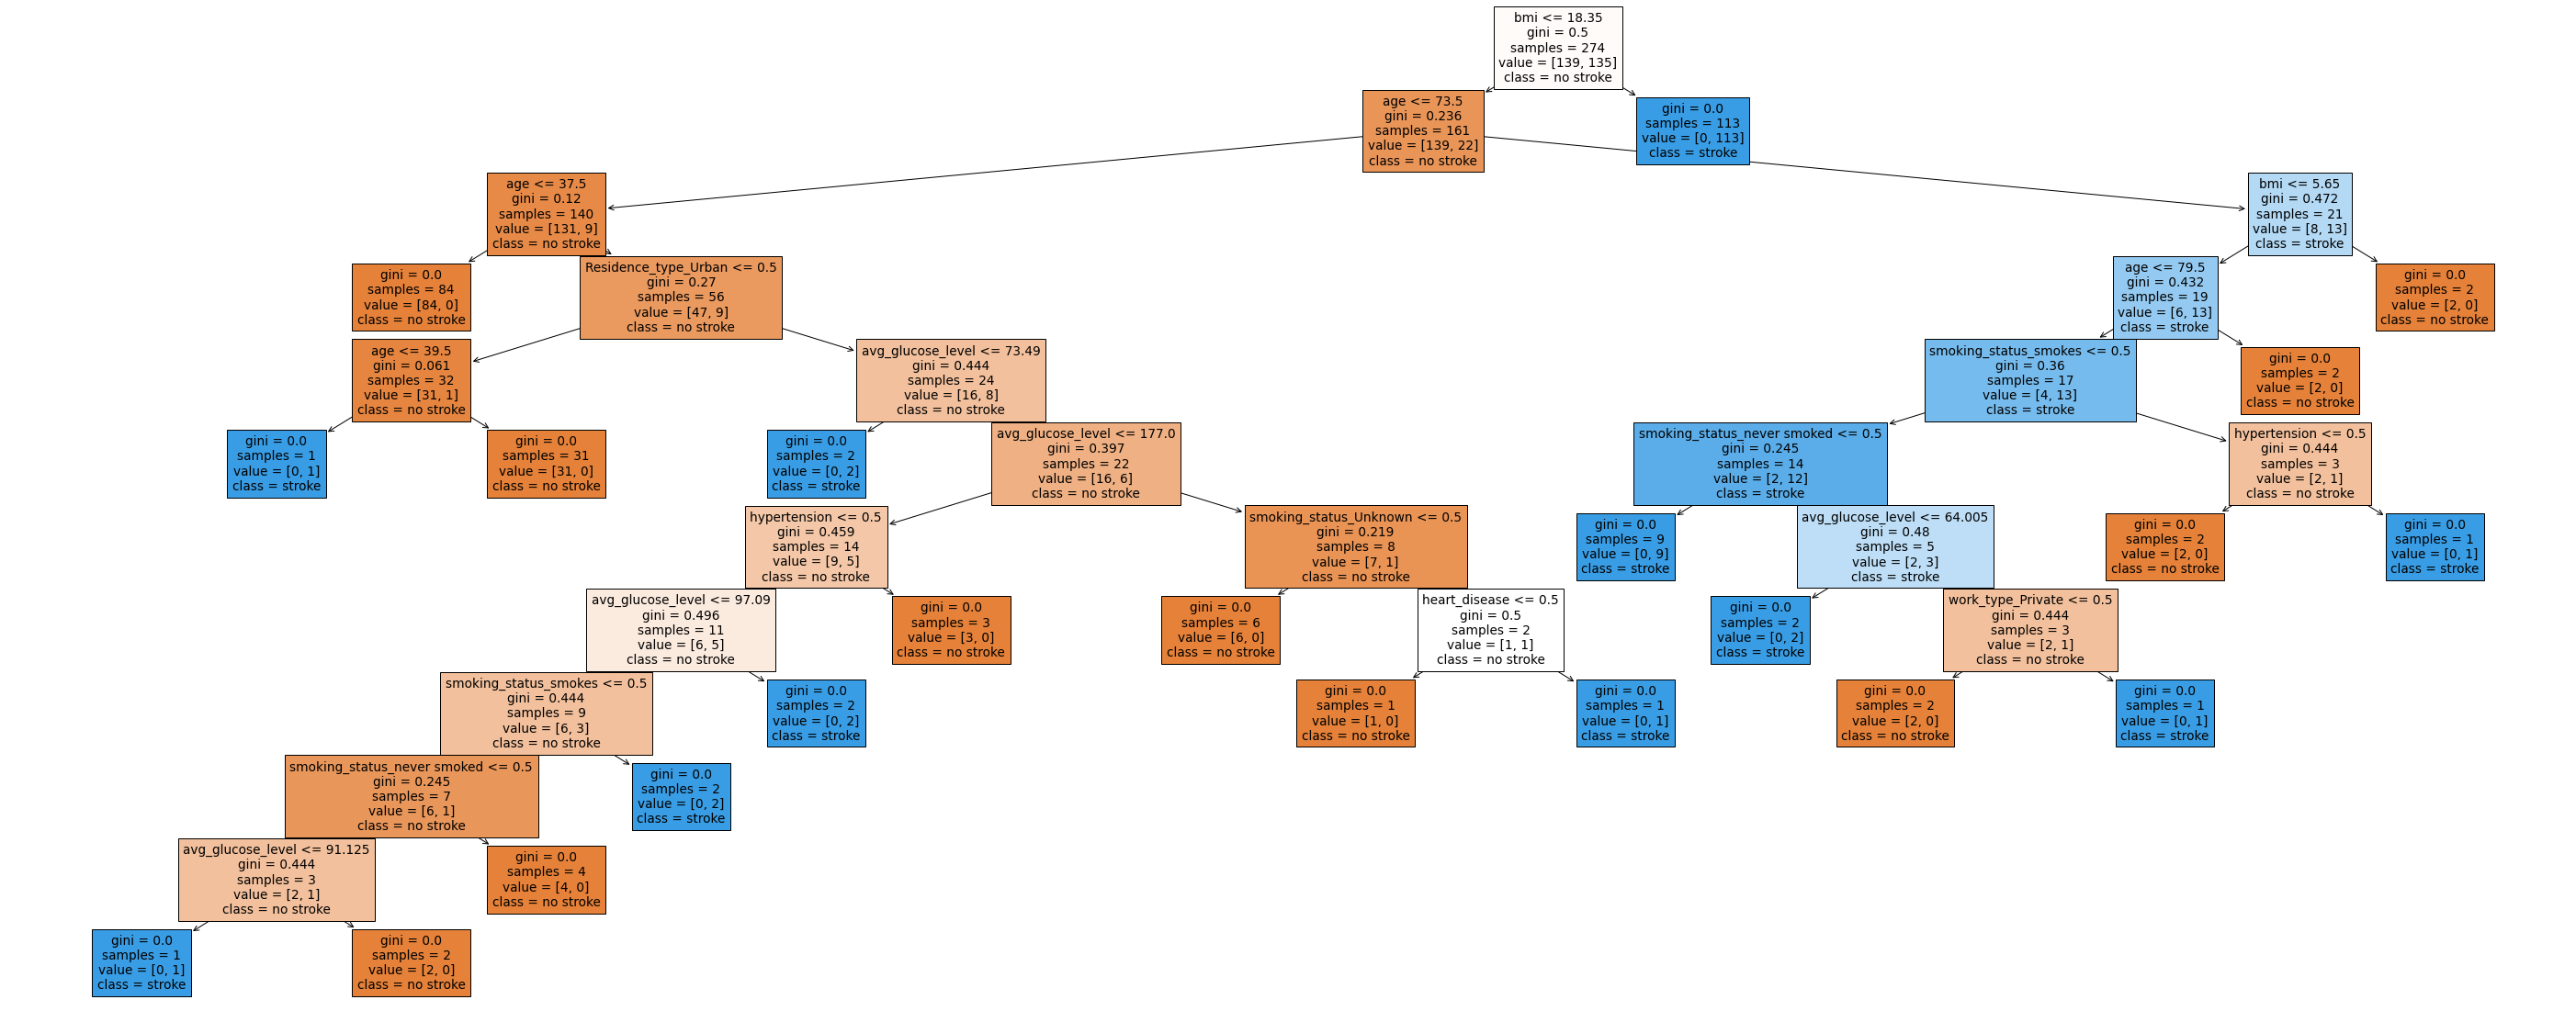

In [69]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(50, 20))
plot_tree(model, feature_names=dfa.columns, class_names=['no stroke', 'stroke'], filled=True, ax=ax)
plt.show()

# Conclusão

Por fim, ao verificar os resultados da decision tree, podemos afirmar que ela de fato é mais precisa que nosso algoritmo, porém, ainda cita caracteristicas que identificamos através dele, dentre elas a influência da idade, bmi e hipertensão. Ainda podemos refinar o nosso algoritmo, assumindo que seus erros sejam apenas algum imprevisto da implementação e não o uso de um modelo inadequado, seria possivel alcançar maior precisão.